In [54]:
# Importer les bibliothèques nécessaires
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from tensorflow.keras.models import load_model

In [55]:
# Définir le chemin de l'image, la hauteur et la largeur
chemin_image = "/content/kfssudoku.jpg"
hauteur_image = 450
largeur_image = 450

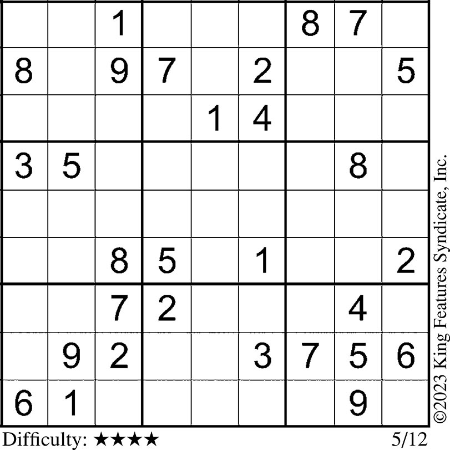

In [56]:
# Lire l'image et la redimensionner en utilisant OpenCV
img = cv2.imread(chemin_image)
img = cv2.resize(img, (largeur_image, hauteur_image))

# Afficher l'image originale
cv2_imshow(img)

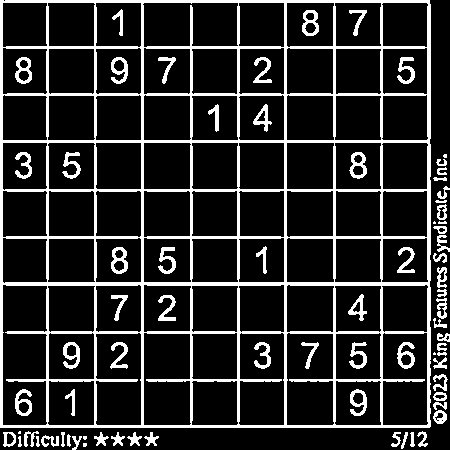

In [57]:
# Convertir l'image en niveau de gris et appliquer un flou gaussien
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_flou = cv2.GaussianBlur(img_gris, (5, 5), 1)

# Appliquer un seuillage adaptatif pour binariser l'image
img_seuil = cv2.adaptiveThreshold(img_flou, 255, 1, 1, 11, 2)

cv2_imshow(img_seuil)

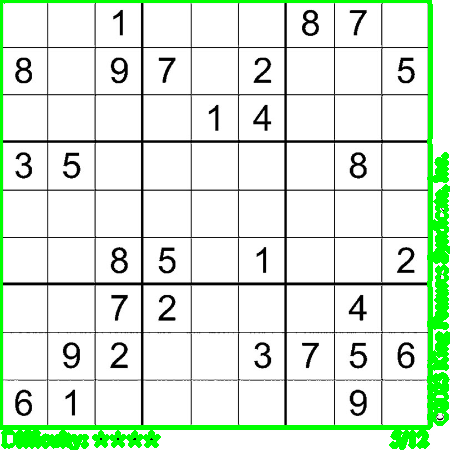

In [58]:
# Trouver les contours de l'image
img_contours = img.copy()
img_contours_grands = img.copy()
contours, hierarchy = cv2.findContours(img_seuil, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 

# Dessiner les contours sur l'image
cv2.drawContours(img_contours, contours, -1, (0, 255, 0), 3)

cv2_imshow(img_contours)

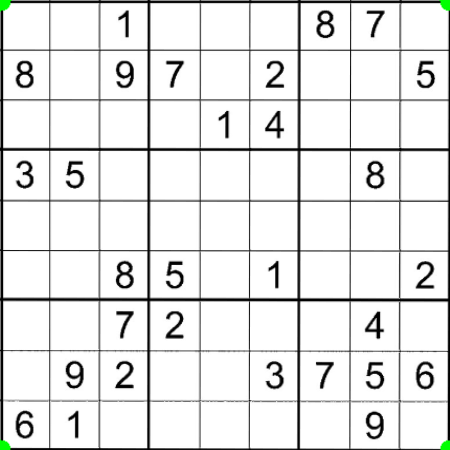

In [59]:
# Trouver le plus grand contour (qui doit être le plateau de sudoku)
plus_grand_contour = np.array([])
max_area = 0
for i in contours:
    area = cv2.contourArea(i)
    if area > 50:
        peri = cv2.arcLength(i, True)
        approx = cv2.approxPolyDP(i, 0.02 * peri, True)
        if area > max_area and len(approx) == 4:
            plus_grand_contour = approx
            max_area = area

# Si le plus grand contour est trouvé, définir les coins du plateau de sudoku
if plus_grand_contour.size != 0:
    plus_grand_contour = plus_grand_contour.reshape((4, 2))
    plus_grand_contour_nouveau = np.zeros((4, 1, 2), dtype=np.int32)
    add = plus_grand_contour.sum(1)
    plus_grand_contour_nouveau[0] = plus_grand_contour[np.argmin(add)]
    plus_grand_contour_nouveau[3] = plus_grand_contour[np.argmax(add)]
    diff = np.diff(plus_grand_contour, axis=1)
    plus_grand_contour_nouveau[1] = plus_grand_contour[np.argmin(diff)]
    plus_grand_contour_nouveau[2] = plus_grand_contour[np.argmax(diff)]

    # Dessiner des cercles sur les coins du plateau de sudoku
    for point in plus_grand_contour_nouveau:
        x, y = point[0]
        cv2.circle(img, (x, y), 10, (0, 255, 0), -1)

    # Définir les points de perspective et appliquer une transformation de perspective pour obtenir une vue de dessus du plateau de sudoku
    pts1 = np.float32(plus_grand_contour_nouveau)
    pts2 = np.float32([[0, 0],[largeur_image, 0], [0, hauteur_image],[largeur_image, hauteur_image]])
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    img_warp_couleur = cv2.warpPerspective(img, matrix, (largeur_image, hauteur_image))
    cv2_imshow(img_warp_couleur)
    
    # Convertir l'image en niveau de gris
    img_chiffres = img.copy()
    img_warp_gris = cv2.cvtColor(img_warp_couleur, cv2.COLOR_BGR2GRAY)

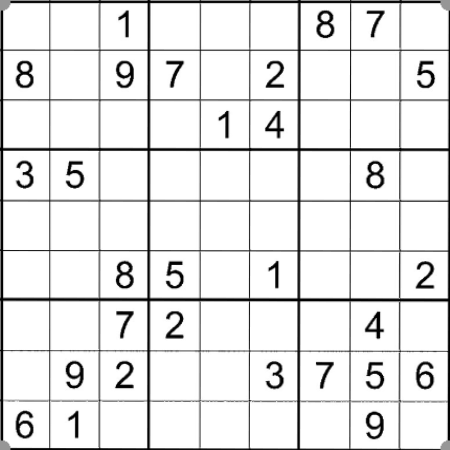

In [60]:
cv2_imshow(img_warp_gris)

81


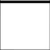

In [61]:
# Découper l'image en 81 cases de sudoku
lignes = np.vsplit(img_warp_gris, 9)
cases = []
for ligne in lignes:
    colonnes = np.hsplit(ligne, 9)
    for case in colonnes:
        cases.append(case)
print(len(cases))

cv2_imshow(cases[3])

In [62]:
 # Charger le modèle de reconnaissance de chiffres
 modele = load_model('/content/model-OCR.h5')


In [63]:
resultat = []
for image in cases:
    img = np.asarray(image)
    img = img[4:img.shape[0] - 4, 4:img.shape[1] -4]
    img = cv2.resize(img, (48, 48))
    img = img / 255
    img = img.reshape(1, 48, 48, 1)

    # Prédire le chiffre dans chaque case
    predictions = modele.predict(img)
    classIndex = np.argmax(predictions, axis = -1)
    probabilityValue = np.max(predictions)

    # Ajouter le chiffre à la liste si la probabilité est supérieure à 0,8
    if probabilityValue > 0.8:
        resultat.append(classIndex[0])
    else:
        resultat.append(0)
 
print(resultat)


1/1 [==============================] - 0s 30ms/step
[0, 0, 1, 0, 0, 0, 8, 7, 0, 8, 0, 9, 7, 0, 2, 0, 0, 5, 0, 0, 0, 0, 1, 4, 0, 0, 0, 3, 5, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 5, 0, 1, 0, 0, 2, 0, 0, 7, 2, 0, 0, 0, 4, 0, 0, 9, 2, 0, 0, 3, 7, 5, 6, 6, 1, 0, 0, 0, 0, 0, 9, 0]


In [64]:
# Créer une image noire pour afficher les chiffres détectés
img_chiffres_detectes = np.zeros((hauteur_image, largeur_image, 3), np.uint8)


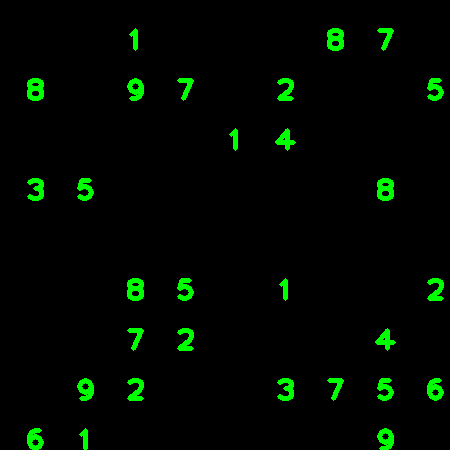

In [65]:
# Écrire les chiffres détectés sur l'image noire
couleur = (0,255,0)
for x in range (0,9):
    for y in range (0,9):
        if resultat[(y*9)+x] != 0 :
            cv2.putText(img_chiffres_detectes, str(resultat[(y*9)+x]),(x*50+25, y*50+50), cv2.FONT_HERSHEY_PLAIN, 2, couleur, 3)

# Afficher l'image des chiffres détectés
cv2_imshow(img_chiffres_detectes)

In [66]:
# Convertir la liste de chiffres détectés en un tableau 9x9
resultat = np.asarray(resultat)

#trouver la position ou y a les cases vides
posArray = np.where(resultat > 0, 0, 1)

#cree un tableau de tableau pour le passer a la fonction de solve
tableau = np.array_split(resultat,9)

print(resultat)
print(posArray)
print(tableau)

[0 0 1 0 0 0 8 7 0 8 0 9 7 0 2 0 0 5 0 0 0 0 1 4 0 0 0 3 5 0 0 0 0 0 8 0 0
 0 0 0 0 0 0 0 0 0 0 8 5 0 1 0 0 2 0 0 7 2 0 0 0 4 0 0 9 2 0 0 3 7 5 6 6 1
 0 0 0 0 0 9 0]
[1 1 0 1 1 1 0 0 1 0 1 0 0 1 0 1 1 0 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 0 1 1 0 0 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 0
 1 1 1 1 1 0 1]
[array([0, 0, 1, 0, 0, 0, 8, 7, 0]), array([8, 0, 9, 7, 0, 2, 0, 0, 5]), array([0, 0, 0, 0, 1, 4, 0, 0, 0]), array([3, 5, 0, 0, 0, 0, 0, 8, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 8, 5, 0, 1, 0, 0, 2]), array([0, 0, 7, 2, 0, 0, 0, 4, 0]), array([0, 9, 2, 0, 0, 3, 7, 5, 6]), array([6, 1, 0, 0, 0, 0, 0, 9, 0])]


In [67]:
#https://data-flair.training/blogs/opencv-sudoku-solver/

def solve(bo):
    find = find_empty(bo)
    if not find:
        return True
    else:
        row, col = find
    for i in range(1,10):
        if valid(bo, i, (row, col)):
            bo[row][col] = i
            if solve(bo):
                return True
            bo[row][col] = 0
    return False

def valid(bo, num, pos):
    # Check row
    for i in range(len(bo[0])):
        if bo[pos[0]][i] == num and pos[1] != i:
            return False
    # Check column
    for i in range(len(bo)):
        if bo[i][pos[1]] == num and pos[0] != i:
            return False
    # Check box
    box_x = pos[1] // 3
    box_y = pos[0] // 3
    for i in range(box_y*3, box_y*3 + 3):
        for j in range(box_x * 3, box_x*3 + 3):
            if bo[i][j] == num and (i,j) != pos:
                return False
    return True

def print_board(bo):
    for i in range(len(bo)):
        if i % 3 == 0 and i != 0:
            print("- - - - - - - - - - - - - ")
        for j in range(len(bo[0])):
            if j % 3 == 0 and j != 0:
                print(" | ", end="")
            if j == 8:
                print(bo[i][j])
            else:
                print(str(bo[i][j]) + " ", end="")

def find_empty(bo):
    for i in range(len(bo)):
        for j in range(len(bo[0])):
            if bo[i][j] == 0:
                return (i, j)  # row, col
    return None

In [68]:
try:
    solve(tableau)
except:
    pass
print(tableau)
flatList = []
for sublist in tableau:
    for item in sublist:
        flatList.append(item)
nombres_resolus =flatList*posArray

print(nombres_resolus)



[array([2, 6, 1, 3, 5, 9, 8, 7, 4]), array([8, 4, 9, 7, 6, 2, 3, 1, 5]), array([7, 3, 5, 8, 1, 4, 6, 2, 9]), array([3, 5, 4, 6, 2, 7, 9, 8, 1]), array([1, 2, 6, 9, 4, 8, 5, 3, 7]), array([9, 7, 8, 5, 3, 1, 4, 6, 2]), array([5, 8, 7, 2, 9, 6, 1, 4, 3]), array([4, 9, 2, 1, 8, 3, 7, 5, 6]), array([6, 1, 3, 4, 7, 5, 2, 9, 8])]
[2 6 0 3 5 9 0 0 4 0 4 0 0 6 0 3 1 0 7 3 5 8 0 0 6 2 9 0 0 4 6 2 7 9 0 1 1
 2 6 9 4 8 5 3 7 9 7 0 0 3 0 4 6 0 5 8 0 0 9 6 1 0 3 4 0 0 1 8 0 0 0 0 0 0
 3 4 7 5 2 0 8]


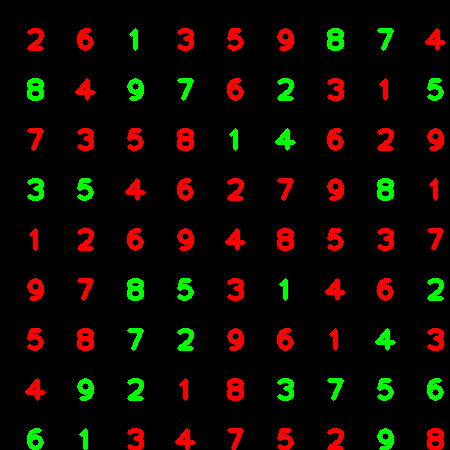

In [70]:
# Créer une image noire
img_chiffres_resolus = img_chiffres_detectes.copy()

# Définir la couleur des chiffres en vert
color = (0,0,255)   

for x in range (0,9):      
    for y in range (0,9):       
        if nombres_resolus[(y*9)+x] != 0 :     
          cv2.putText(img_chiffres_resolus, str(nombres_resolus[(y*9)+x]),(x*50+25, y*50+50),  
              cv2.FONT_HERSHEY_PLAIN, 2, color, 3)

# Afficher l'image
cv2_imshow(img_chiffres_resolus)  